##Predicting Galaxy Flux with ML

Jin Wuk Lee & Jinwoo Kim

# Preliminaries

In [ ]:
# Pip installations
!pip install fitsdataset
!pip install tqdm

Mounting Drive for different users

In [ ]:
# Jinwoo
from google.colab import drive
import os

# Mount Drive
drive.mount('/content/drive')
# Change present directory to Final Project folder
os.chdir("/content/drive/MyDrive/PHYS378_Final_Project")

# Set paths to important files
train_path = "./gal_morph_train_val.csv"
test_path = "./gal_morph_test.csv"

# Display current directory (should end in .../PHYS378 Final Project)
os.getcwd()

Mounted at /content/drive


'/content/drive/MyDrive/PHYS378_Final_Project'

In [ ]:
# Jin Wuk
from google.colab import drive
import os

# Mount Drive
drive.mount('/content/drive')
# Change present directory to Final Project folder
os.chdir("/content/drive/MyDrive/Yale 2024-2025/PHYS378/PHYS378_Final_Project")

# Set paths to important files
train_path = "./gal_morph_train_val.csv"
test_path = "./gal_morph_test.csv"
tensors_path = "./tensors.csv"

# Display current directory (should end in .../PHYS378 Final Project)
os.getcwd()

Mounted at /content/drive


'/content/drive/.shortcut-targets-by-id/18D7HWPsMcxfrnVw2RDAMk2Y8-Tg3cDeu/PHYS378_Final_Project'

GPU

In [ ]:
import torch

if torch.cuda.is_available():
    print("GPU is available!")
else:
    print("GPU is not available.")

GPU is available!


# Data Processing

In [ ]:
# Initial data processing

import pandas as pd

# Load the CSV files
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
#tensors_df = pd.read_csv(tensors_path)

# Display the first few rows of the updated DataFrames
print("Training Data:")
print(train_df.head())

print("\nTest Data:")
print(test_df.head())

Training Data:
   img_number  num_components  sersic_idx_d  R_e_d  axis_ratio_d    PA_d  \
0       27248               2         0.827  0.106         0.628 -42.580   
1       67161               2         0.840  2.082         0.265  -0.769   
2       27247               2         1.148  0.552         0.368  36.512   
3        7257               2         0.952  1.315         0.374  40.700   
4       85233               2         0.984  0.283         0.851  80.519   

   flux_frac_d  sersic_idx_b  R_e_b  axis_ratio_b    PA_b  flux_frac_b  \
0        0.024         4.113  1.427         0.857 -38.070        0.976   
1        0.564         4.631  1.533         0.918  10.391        0.436   
2        0.755         4.531  1.399         0.973  43.542        0.245   
3        0.107         4.951  0.151         0.983  35.853        0.893   
4        0.158         4.586  0.232         0.667  88.126        0.842   

   total_flux  log_total_flux   file_name       R_e     bt  
0   23092.184        4

In [ ]:
tensor_df = pd.read_pickle("./tensors_df.pkl") # Dataset of tensors corresponding to image data

Data Visualizations

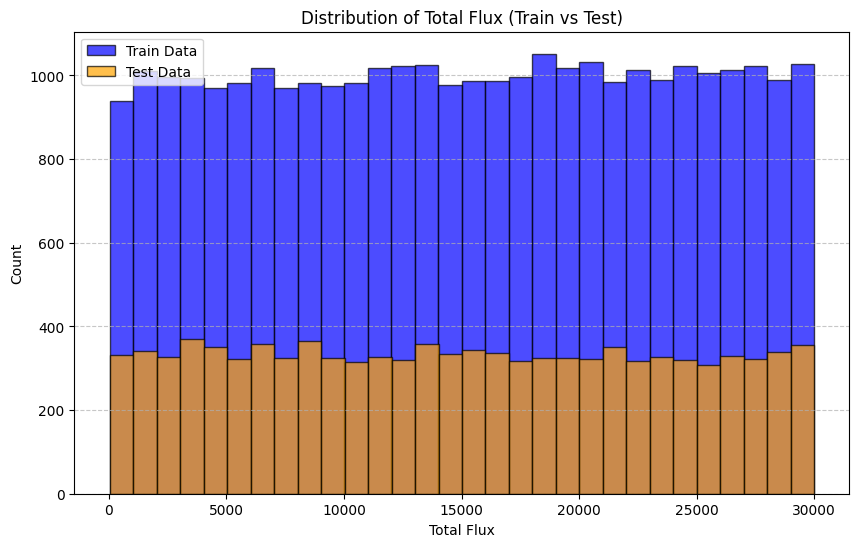

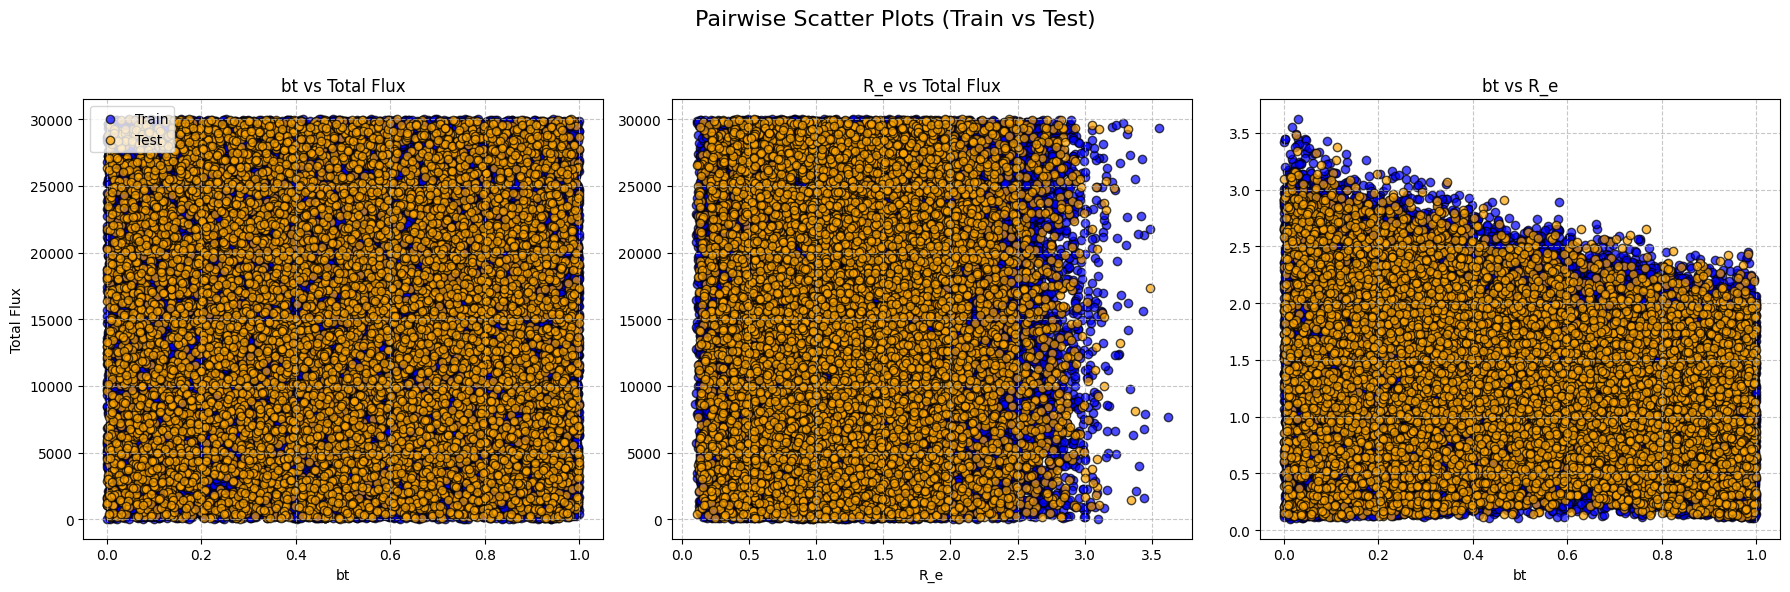

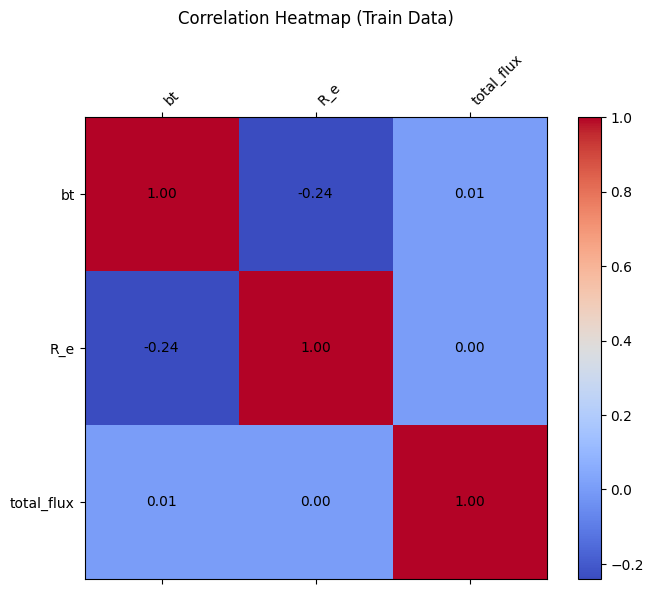

In [ ]:
# Visualizing the train and test datasets

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Combine train and test data for easier visualization
train_df['dataset'] = 'Train'
test_df['dataset'] = 'Test'
combined_df = pd.concat([train_df, test_df], ignore_index=True)

# Visualization 1: Histogram of Total Flux
plt.figure(figsize=(10, 6))
for dataset, color in zip(['Train', 'Test'], ['blue', 'orange']):
    subset = combined_df[combined_df['dataset'] == dataset]
    plt.hist(
        subset['total_flux'],
        bins=30,
        alpha=0.7,
        label=f"{dataset} Data",
        color=color,
        edgecolor="black"
    )
plt.title("Distribution of Total Flux (Train vs Test)")
plt.xlabel("Total Flux")
plt.ylabel("Count")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Visualization 3: Pairwise Scatter Plots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=False)

# bt vs Total Flux
axes[0].scatter(train_df['bt'], train_df['total_flux'], alpha=0.7, label="Train", color='blue', edgecolor='k')
axes[0].scatter(test_df['bt'], test_df['total_flux'], alpha=0.7, label="Test", color='orange', edgecolor='k')
axes[0].set_title("bt vs Total Flux")
axes[0].set_xlabel("bt")
axes[0].set_ylabel("Total Flux")
axes[0].legend()

# R_e vs Total Flux
axes[1].scatter(train_df['R_e'], train_df['total_flux'], alpha=0.7, label="Train", color='blue', edgecolor='k')
axes[1].scatter(test_df['R_e'], test_df['total_flux'], alpha=0.7, label="Test", color='orange', edgecolor='k')
axes[1].set_title("R_e vs Total Flux")
axes[1].set_xlabel("R_e")

# bt vs R_e
axes[2].scatter(train_df['bt'], train_df['R_e'], alpha=0.7, label="Train", color='blue', edgecolor='k')
axes[2].scatter(test_df['bt'], test_df['R_e'], alpha=0.7, label="Test", color='orange', edgecolor='k')
axes[2].set_title("bt vs R_e")
axes[2].set_xlabel("bt")

# Common settings
for ax in axes:
    ax.grid(linestyle='--', alpha=0.7)
fig.suptitle("Pairwise Scatter Plots (Train vs Test)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Visualization 4: Correlation Heatmap (Train Data)
correlation_matrix = train_df[["bt", "R_e", "total_flux"]].corr()

fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.matshow(correlation_matrix, cmap='coolwarm')
fig.colorbar(cax)

# Add labels
ax.set_xticks(range(correlation_matrix.shape[1]))
ax.set_yticks(range(correlation_matrix.shape[0]))
ax.set_xticklabels(correlation_matrix.columns, rotation=45, ha='left')
ax.set_yticklabels(correlation_matrix.index)

for (i, j), val in np.ndenumerate(correlation_matrix.values):
    ax.text(j, i, f"{val:.2f}", ha='center', va='center', color='black')

plt.title("Correlation Heatmap (Train Data)", pad=20)
plt.show()


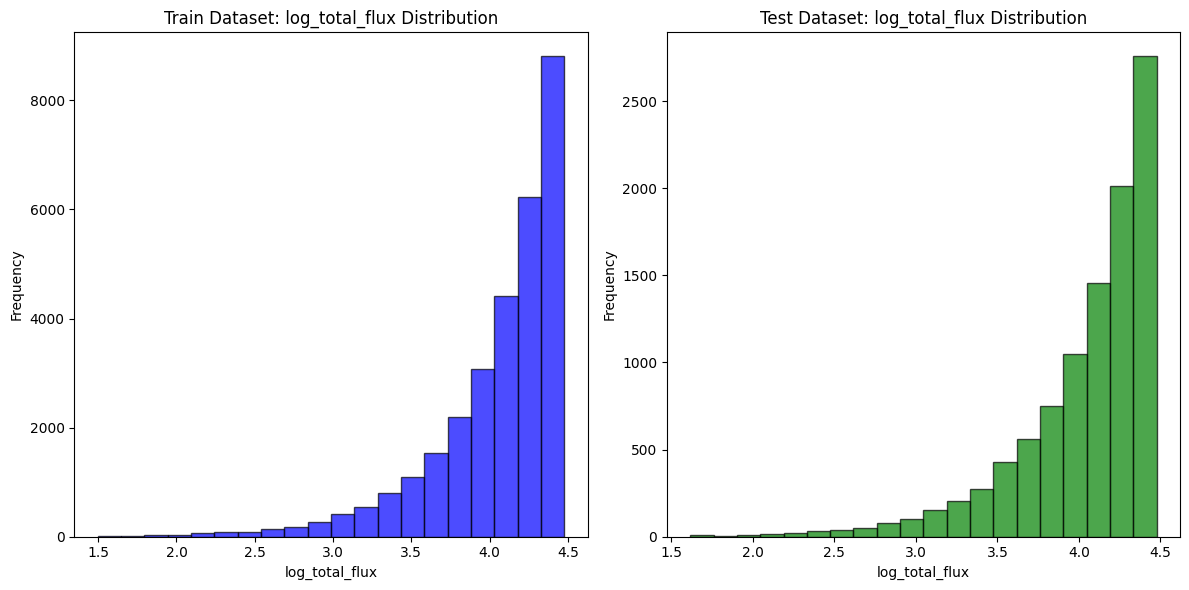

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Plot the distributions of log_total_flux
plt.figure(figsize=(12, 6))

# Train dataset
plt.subplot(1, 2, 1)
plt.hist(train_df['log_total_flux'], bins=20, color='blue', alpha=0.7, edgecolor='black')
plt.title('Train Dataset: log_total_flux Distribution')
plt.xlabel('log_total_flux')
plt.ylabel('Frequency')

# Test dataset
plt.subplot(1, 2, 2)
plt.hist(test_df['log_total_flux'], bins=20, color='green', alpha=0.7, edgecolor='black')
plt.title('Test Dataset: log_total_flux Distribution')
plt.xlabel('log_total_flux')
plt.ylabel('Frequency')

# Show the plots
plt.tight_layout()
plt.show()

In [ ]:
df = pd.read_csv(train_path)
df

,img_number,num_components,sersic_idx_d,R_e_d,axis_ratio_d,PA_d,flux_frac_d,sersic_idx_b,R_e_b,axis_ratio_b,PA_b,flux_frac_b,total_flux,log_total_flux,file_name,R_e,bt
0,27248,2,0.827,0.106,0.628,-42.580,0.024,4.113,1.427,0.857,-38.070,0.976,23092.184,4.363465,27248.fits,1.372930,0.976
1,67161,2,0.840,2.082,0.265,-0.769,0.564,4.631,1.533,0.918,10.391,0.436,7516.552,3.876019,67161.fits,2.169138,0.436
2,27247,2,1.148,0.552,0.368,36.512,0.755,4.531,1.399,0.973,43.542,0.245,9944.074,3.997564,27247.fits,0.690142,0.245
3,7257,2,0.952,1.315,0.374,40.700,0.107,4.951,0.151,0.983,35.853,0.893,28716.708,4.458135,7257.fits,0.193666,0.893
4,85233,2,0.984,0.283,0.851,80.519,0.158,4.586,0.232,0.667,88.126,0.842,18224.146,4.260647,85233.fits,0.245004,0.842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,36465,2,1.147,1.657,0.959,-89.785,0.882,4.159,0.112,0.560,-81.184,0.118,17776.562,4.249848,36465.fits,1.452797,0.118
29996,43881,2,1.131,1.542,0.503,45.036,0.078,4.705,1.034,0.603,39.433,0.922,13802.180,4.139948,43881.fits,1.129090,0.922
29997,72287,2,1.088,2.830,0.817,76.970,0.326,4.356,1.908,0.321,82.387,0.674,26411.818,4.421798,72287.fits,2.493842,0.674
29998,27010,2,1.116,0.345,0.448,-37.761,0.002,4.370,0.116,0.504,-25.391,0.998,19798.688,4.296636,27010.fits,0.128702,0.998


In [ ]:
df = pd.read_csv(test_path)
df

,img_number,num_components,sersic_idx_d,R_e_d,axis_ratio_d,PA_d,flux_frac_d,sersic_idx_b,R_e_b,axis_ratio_b,PA_b,flux_frac_b,total_flux,log_total_flux,file_name,R_e,bt
0,32643,2,1.014,1.199,0.639,61.712,0.308,4.571,0.848,0.879,52.272,0.692,5156.289,3.712337,32643.fits,1.011479,0.692
1,50987,2,0.902,0.196,0.718,-19.551,0.417,4.448,0.570,0.337,-33.917,0.583,6811.969,3.833273,50987.fits,0.310336,0.583
2,16675,2,0.942,2.166,0.338,53.993,0.813,3.915,1.625,0.264,68.374,0.187,27816.620,4.444304,16675.fits,2.403628,0.187
3,40761,2,1.036,0.177,0.881,80.326,0.066,4.490,1.263,0.405,76.140,0.934,11753.862,4.070181,40761.fits,1.215200,0.934
4,84531,2,0.881,0.294,0.808,-2.380,0.222,4.399,0.108,0.522,-0.266,0.778,27308.865,4.436304,84531.fits,0.152436,0.778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,91373,2,1.008,1.986,0.262,59.050,0.571,4.267,1.194,0.717,62.091,0.429,28497.684,4.454810,91373.fits,1.955058,0.429
9996,60757,2,1.104,1.311,0.372,-15.546,0.664,4.983,1.821,0.574,-26.597,0.336,27491.874,4.439204,60757.fits,1.545260,0.336
9997,2908,2,0.811,2.040,0.579,-50.427,0.072,4.359,1.823,0.312,-54.642,0.928,26370.610,4.421120,2908.fits,2.133142,0.928
9998,33259,2,0.943,2.509,0.668,87.767,0.242,3.680,1.922,0.496,74.582,0.758,24575.585,4.390504,33259.fits,2.218914,0.758


(239, 239)


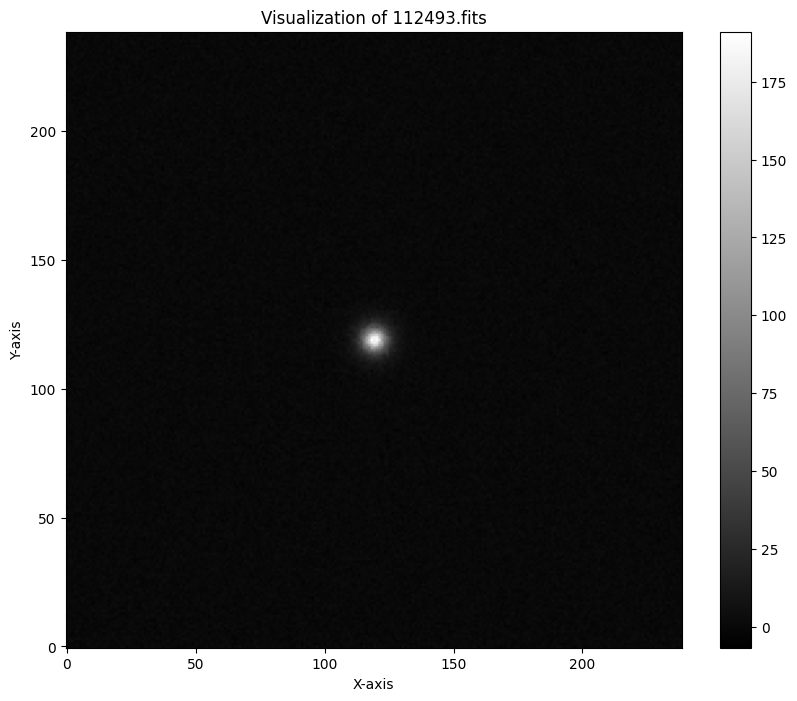

In [ ]:
from astropy.io import fits
import matplotlib.pyplot as plt

# Load the FITS file
fits_file = "./images/112493.fits"
data = fits.getdata(fits_file)
print(data.shape)

# Plot the data
plt.figure(figsize=(10, 8))
plt.imshow(data, cmap='gray', origin='lower')
plt.colorbar()  # Add a colorbar for reference
plt.title("Visualization of 112493.fits")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.show()

# Basic regression models

Linear Regression Model

Mean Squared Error: 0.1788817702874767
R² Score: -0.0015041132093094323


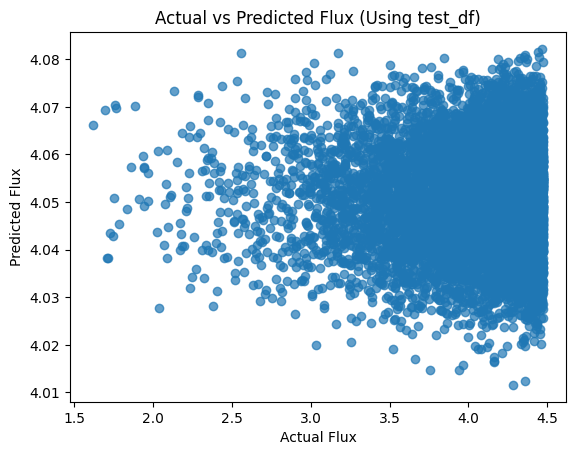

In [ ]:
# Linear Regression Model

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Step 1: Load the data

# Step 2: Preprocess the data
# Prepare training data
X_train = train_df.drop(columns=['log_total_flux', 'total_flux', 'file_name'])
y_train = train_df['log_total_flux']

# Prepare testing data
X_test = test_df.drop(columns=['log_total_flux', 'total_flux', 'file_name'])
y_test = test_df['log_total_flux']

# Step 3: Train a Linear Regression Model
model = LinearRegression()
model.fit(X_train, y_train)

# Step 4: Evaluate the Model
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")

# Optional: Visualize Predictions vs. Actuals
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel("Actual Flux")
plt.ylabel("Predicted Flux")
plt.title("Actual vs Predicted Flux (Using test_df)")
plt.show()

Linear Regression Model (R_e and Bt)

Mean Squared Error: 0.17867582251303873
R² Score: -0.00035107484841634395


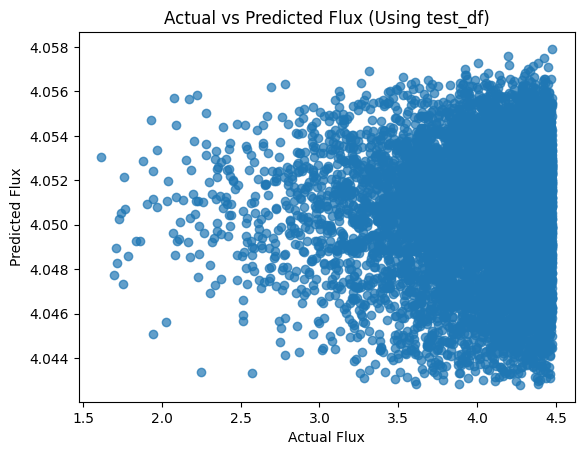

In [ ]:
# Linear Regression Model (R_e and bt)

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Prepare training data
X_train = train_df[['R_e', 'bt']]
y_train = train_df['log_total_flux']

# Prepare testing data
X_test = test_df[['R_e', 'bt']]
y_test = test_df['log_total_flux']

#Train a Linear Regression Model
model = LinearRegression()
model.fit(X_train, y_train)

#Evaluate the Model
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")

# Optional: Visualize Predictions vs. Actuals
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel("Actual Flux")
plt.ylabel("Predicted Flux")
plt.title("Actual vs Predicted Flux (Using test_df)")
plt.show()


Looks similar, even though the second model only uses two variables R_e and bt...

Logistic Regression Model

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.34

Classification Report:
              precision    recall  f1-score   support

        High       0.35      0.35      0.35      3333
         Low       0.34      0.38      0.36      3334
      Medium       0.33      0.29      0.31      3333

    accuracy                           0.34     10000
   macro avg       0.34      0.34      0.34     10000
weighted avg       0.34      0.34      0.34     10000



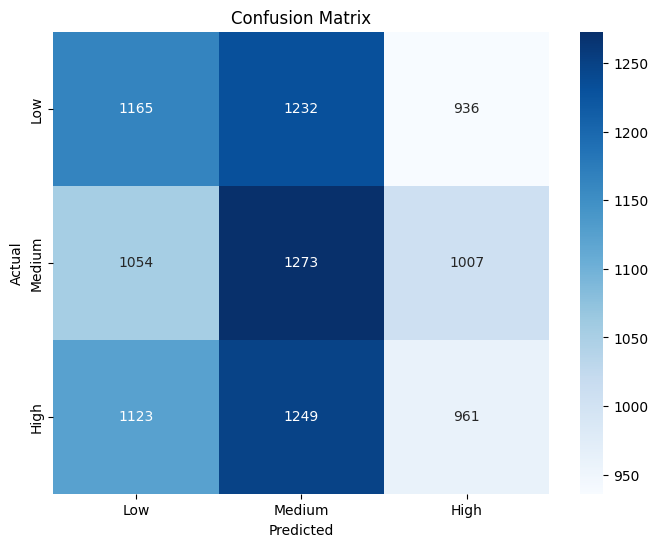

In [ ]:
# Logistic Regression Model

import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Preprocess the data
# Bin the target variable into 3 categories (e.g., low, medium, high)
num_bins = 3  # Define the number of bins
bin_labels = ['Low', 'Medium', 'High']  # Define labels for the bins
train_df['flux_category'] = pd.qcut(train_df['log_total_flux'], q=num_bins, labels=bin_labels)
test_df['flux_category'] = pd.qcut(test_df['log_total_flux'], q=num_bins, labels=bin_labels)

# Prepare features and categorical target
X_train = train_df.drop(columns=['log_total_flux', 'total_flux', 'file_name', 'flux_category'])
y_train = train_df['flux_category']

X_test = test_df.drop(columns=['log_total_flux', 'total_flux', 'file_name', 'flux_category'])
y_test = test_df['flux_category']

# Step 2: Train a Logistic Regression Model
model = LogisticRegression(max_iter=1000)  # Increase max_iter for convergence
model.fit(X_train, y_train)

# Step 3: Evaluate the Model
y_pred = model.predict(X_test)

# Classification Metrics
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=bin_labels, yticklabels=bin_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Also pretty bad... but we knew that it would be

Random Forest Regression

Accuracy: 0.34

Classification Report:
              precision    recall  f1-score   support

        High       0.34      0.36      0.35      3333
         Low       0.33      0.32      0.33      3334
      Medium       0.33      0.32      0.33      3333

    accuracy                           0.34     10000
   macro avg       0.33      0.34      0.33     10000
weighted avg       0.33      0.34      0.33     10000



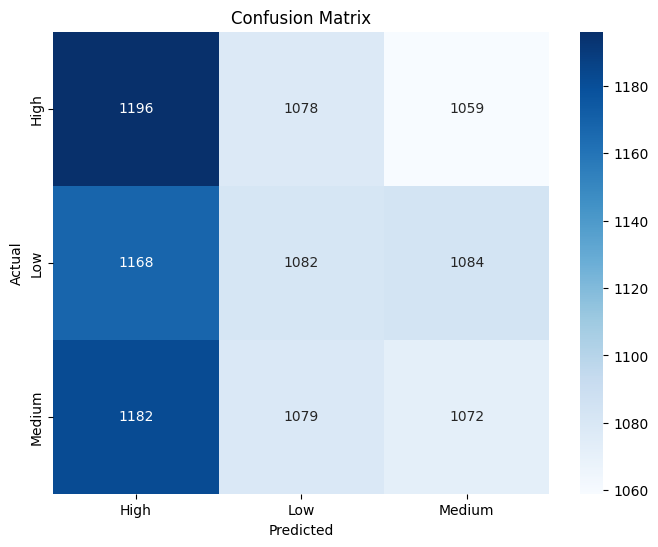

In [ ]:
# Random Forest Regression

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Preprocess the data
# Bin the target variable into 3 categories (e.g., low, medium, high)
num_bins = 3  # Define the number of bins
bin_labels = ['Low', 'Medium', 'High']  # Define labels for the bins
train_df['flux_category'] = pd.qcut(train_df['log_total_flux'], q=num_bins, labels=bin_labels)
test_df['flux_category'] = pd.qcut(test_df['log_total_flux'], q=num_bins, labels=bin_labels)

# Prepare features and categorical target
X_train = train_df.drop(columns=['log_total_flux', 'total_flux', 'file_name', 'flux_category'])
y_train = train_df['flux_category']

X_test = test_df.drop(columns=['log_total_flux', 'total_flux', 'file_name', 'flux_category'])
y_test = test_df['flux_category']

# Step 2: Train a Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42)  # Default settings
model.fit(X_train, y_train)

# Step 3: Evaluate the Model
y_pred = model.predict(X_test)

# Classification Metrics
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# Convolution Neural Network (CNN)

Create data loader

In [ ]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from astropy.io import fits
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

# Function to load and preprocess .fits images
def load_and_preprocess_fits(file_path, target_size=(128, 128)):
    image_data = fits.getdata(file_path)
    # Normalize and resize the image
    image_resized = tf.image.resize(image_data, target_size)
    image_normalized = image_resized / tf.reduce_max(image_resized)
    return image_normalized.numpy() # Convert to a NumPy array

# Process the folder of .fits files
def process_fits_folder(folder_path, target_size=(128, 128)):
    file_names = []
    tensors = []

    for file_name in os.listdir(folder_path):
        if file_name.endswith('.fits'):
            file_path = os.path.join(folder_path, file_name)
            tensor = load_and_preprocess_fits(file_path, target_size)
            file_names.append(file_name)
            tensors.append(tensor)

    return file_names, tensors

# Creating data loader
# Assuming train_csv and tensor_df are already loaded
flux_train = []
flux_test = []

# Iterate through the rows of train_csv
for index, row in train_df.iterrows():
    # Get the file_name from train_csv
    file_name = row['file_name']

    # Find the corresponding row in tensor_df with the same file_name
    tensor_row = tensor_df.loc[tensor_df['file_name'] == file_name]

    # Print the 'tensor' column value from tensor_df
    if not tensor_row.empty:  # Check if a match was found
        flux_train.append((tensor_row.iloc[0]['tensor'], row["log_total_flux"]))
    else:
        print(f"No matching tensor found for File Name: {file_name}")

# Iterate through the rows of test_csv
for index, row in test_df.iterrows():
    # Get the file_name from train_csv
    file_name = row['file_name']

    # Find the corresponding row in tensor_df with the same file_name
    tensor_row = tensor_df.loc[tensor_df['file_name'] == file_name]

    # Print the 'tensor' column value from tensor_df
    if not tensor_row.empty:  # Check if a match was found
        flux_test.append((tensor_row.iloc[0]['tensor'], row["log_total_flux"]))
    else:
        print(f"No matching tensor found for File Name: {file_name}")

# Custom Dataset class
class FluxDataset(Dataset):
    def __init__(self, data):
        """
        Args:
            data (list): List of (tensor, label) tuples.
        """
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image, label = self.data[idx]
        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)  # Add channel dimension
        label = torch.tensor(label, dtype=torch.float32)
        return image, label

# Create train and test DataLoaders
train_dataset = FluxDataset(flux_train)
test_dataset = FluxDataset(flux_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Set seeds for reproducibility

In [ ]:
# Set seeds for each library
seed_value = 42
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed(seed_value)  # If using CUDA

Model 1

In [ ]:
# Regression CNN model 1
# 7 epochs, learning rate 0.01

class RegressionNetwork(nn.Module):
    def __init__(self):
        super(RegressionNetwork, self).__init__()
        # Convolution layers
        self.convolutaional_neural_network_layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=12, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        # Linear layer
        self.linear_layers = nn.Sequential(
            nn.Linear(in_features=24*35*35, out_features=64),  # Adjusted input size
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(in_features=64, out_features=1)  # Single output for regression
        )

    def forward(self, x):
        x = self.convolutaional_neural_network_layers(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.linear_layers(x)
        return x

# Initialize model, loss function, and optimizer
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = RegressionNetwork().to(device)
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Train the model
for epoch in range(7):
    model.train()
    train_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        output = model(images)
        loss = criterion(output.squeeze(), labels)  # Squeeze to match shape
        train_loss += loss.item()

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluate on the test set
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            output = model(images)
            loss = criterion(output.squeeze(), labels)
            test_loss += loss.item()

    print(f'Epoch {epoch+1}/7: Train Loss={train_loss/len(train_loader):.4f}, Test Loss={test_loss/len(test_loader):.4f}')


Epoch 1/7: Train Loss=32.9182, Test Loss=0.2283
Epoch 2/7: Train Loss=0.6601, Test Loss=0.1983
Epoch 3/7: Train Loss=0.5443, Test Loss=0.1855
Epoch 4/7: Train Loss=0.4037, Test Loss=0.1808
Epoch 5/7: Train Loss=0.2854, Test Loss=0.1891
Epoch 6/7: Train Loss=0.2130, Test Loss=0.1805
Epoch 7/7: Train Loss=0.1844, Test Loss=0.1781


Results of Model 1

In [ ]:
# Function to predict and compare flux
def predict_and_compare(model, dataset, num_samples=10):
    model.eval()  # Set the model to evaluation mode
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    predictions = []
    actuals = []
    file_names = []

    # Loop through the first `num_samples` rows of the dataset
    for i in range(num_samples):
        image, label = dataset[i]  # Get image and label from the dataset
        file_name = test_df.iloc[i]['file_name']  # Get the corresponding file_name

        # Convert image to PyTorch tensor, add batch dimension, and move to device
        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0).to(device)

        # Predict using the model
        with torch.no_grad():
            predicted_flux = model(image).item()  # Get the single prediction as a scalar

        # Append results for comparison
        predictions.append(predicted_flux)
        actuals.append(label.item())
        file_names.append(file_name)

    # Print the results
    print(f"{'File Name':<20}{'Predicted':<20}{'Actual':<20}{'Difference':<20}")
    print("-" * 80)
    for file_name, pred, actual in zip(file_names, predictions, actuals):
        print(f"{file_name:<20}{pred:<20.6f}{actual:<20.6f}{abs(pred - actual):<20.6f}")

# Predict and compare the flux for the first 10 rows of test_csv
predict_and_compare(model, test_dataset, num_samples=10)

File Name           Predicted           Actual              Difference          
--------------------------------------------------------------------------------
32643.fits          4.026822            3.712337            0.314485            
50987.fits          4.026822            3.833273            0.193549            
16675.fits          4.026822            4.444304            0.417482            
40761.fits          4.026822            4.070180            0.043358            
84531.fits          4.175019            4.436304            0.261284            
33715.fits          4.026822            4.440171            0.413349            
63863.fits          4.026822            2.466246            1.560576            
68747.fits          4.026822            4.356729            0.329906            
43169.fits          4.026822            4.331399            0.304577            
106470.fits         4.026822            4.299706            0.272884            


<ipython-input-9-131564ad849a>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32).unsqueeze(0).to(device)


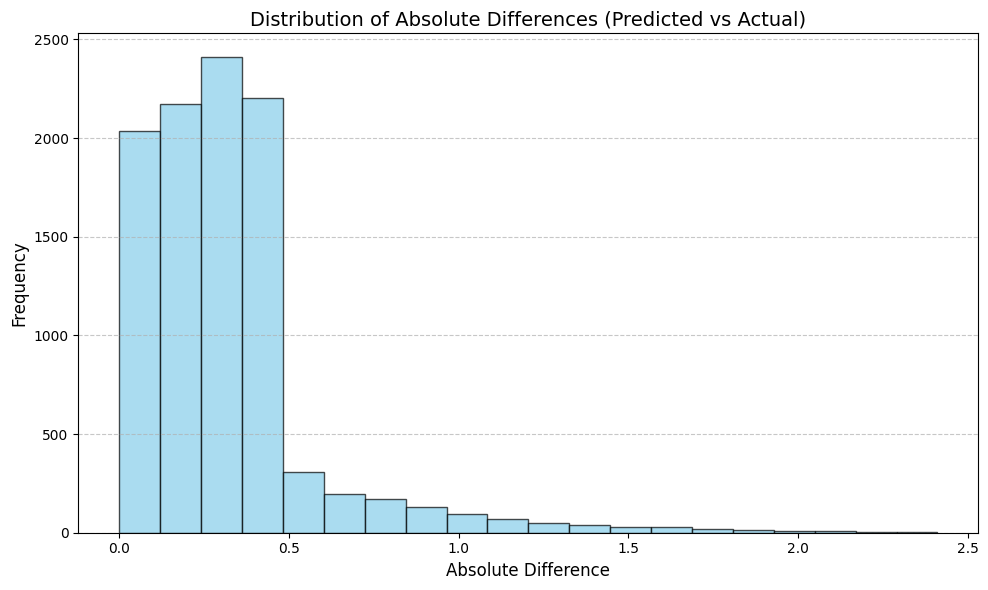

In [ ]:
import torch
import matplotlib.pyplot as plt

# Function to predict for all rows in test_df and plot differences
def predict_and_graph_differences(model, dataset, test_df):
    """
    Predict log_total_flux for all rows in test_df, compute differences, and plot their distribution.

    Args:
        model: Trained PyTorch regression model.
        dataset: Dataset object (FluxDataset) for test data.
        test_df: Pandas DataFrame containing test metadata.
    """
    model.eval()  # Set the model to evaluation mode
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    differences = []  # List to store absolute differences

    # Loop through all rows in test dataset
    for i in range(len(dataset)):
        image, label = dataset[i]  # Get image and label from dataset

        # Ensure the image is a PyTorch tensor, add batch dimension, and move to device
        if isinstance(image, np.ndarray):
            image = torch.tensor(image, dtype=torch.float32)
        image = image.unsqueeze(0).to(device)  # Add batch dimension

        # Predict using the model
        with torch.no_grad():
            predicted_flux = model(image).item()  # Get the single prediction as a scalar

        # Compute the absolute difference
        actual_flux = label.item() if isinstance(label, torch.Tensor) else label
        difference = abs(predicted_flux - actual_flux)
        differences.append(difference)

    # Plot the histogram of differences
    plt.figure(figsize=(10, 6))
    plt.hist(differences, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
    plt.title('Distribution of Absolute Differences (Predicted vs Actual)', fontsize=14)
    plt.xlabel('Absolute Difference', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Predict and graph differences for all rows in test_df
predict_and_graph_differences(model, test_dataset, test_df)

2nd Model

In [ ]:
# 2nd Regression CNN model
# 15 epochs, learning rate 0.001
class RegressionNetwork(nn.Module):
    def __init__(self):
        super(RegressionNetwork, self).__init__()
        # Convolution layers
        self.convolutaional_neural_network_layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=12, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        # Linear layer
        self.linear_layers = nn.Sequential(
            nn.Linear(in_features=24*35*35, out_features=64),  # Adjusted input size
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(in_features=64, out_features=1)  # Single output for regression
        )

    def forward(self, x):
        x = self.convolutaional_neural_network_layers(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.linear_layers(x)
        return x

# Initialize model, loss function, and optimizer
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = RegressionNetwork().to(device)
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
for epoch in range(15):
    model.train()
    train_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        output = model(images)
        loss = criterion(output.squeeze(), labels)  # Squeeze to match shape
        train_loss += loss.item()

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluate on the test set
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            output = model(images)
            loss = criterion(output.squeeze(), labels)
            test_loss += loss.item()

    print(f'Epoch {epoch+1}/15: Train Loss={train_loss/len(train_loader):.4f}, Test Loss={test_loss/len(test_loader):.4f}')


Epoch 1/15: Train Loss=1.2936, Test Loss=0.1134
Epoch 2/15: Train Loss=0.7211, Test Loss=0.0456
Epoch 3/15: Train Loss=0.5746, Test Loss=0.0229
Epoch 4/15: Train Loss=0.4235, Test Loss=0.0219
Epoch 5/15: Train Loss=0.2929, Test Loss=0.0151
Epoch 6/15: Train Loss=0.1894, Test Loss=0.0125
Epoch 7/15: Train Loss=0.1172, Test Loss=0.0106
Epoch 8/15: Train Loss=0.0747, Test Loss=0.0370
Epoch 9/15: Train Loss=0.0588, Test Loss=0.0236
Epoch 10/15: Train Loss=0.0566, Test Loss=0.0346
Epoch 11/15: Train Loss=0.0568, Test Loss=0.0330
Epoch 12/15: Train Loss=0.0560, Test Loss=0.0324
Epoch 13/15: Train Loss=0.0558, Test Loss=0.0295
Epoch 14/15: Train Loss=0.0560, Test Loss=0.0292
Epoch 15/15: Train Loss=0.0561, Test Loss=0.0388


Results of Model 2

In [ ]:
# Function to predict and compare flux
def predict_and_compare(model, dataset, num_samples=10):
    model.eval()  # Set the model to evaluation mode
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    predictions = []
    actuals = []
    file_names = []

    # Loop through the first `num_samples` rows of the dataset
    for i in range(num_samples):
        image, label = dataset[i]  # Get image and label from the dataset
        file_name = test_df.iloc[i]['file_name']  # Get the corresponding file_name

        # Convert image to PyTorch tensor, add batch dimension, and move to device
        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0).to(device)

        # Predict using the model
        with torch.no_grad():
            predicted_flux = model(image).item()  # Get the single prediction as a scalar

        # Append results for comparison
        predictions.append(predicted_flux)
        actuals.append(label.item())
        file_names.append(file_name)

    # Print the results
    print(f"{'File Name':<20}{'Predicted':<20}{'Actual':<20}{'Difference':<20}")
    print("-" * 80)
    for file_name, pred, actual in zip(file_names, predictions, actuals):
        print(f"{file_name:<20}{pred:<20.6f}{actual:<20.6f}{abs(pred - actual):<20.6f}")

# Predict and compare the flux for the first 10 rows of test_csv
predict_and_compare(model, test_dataset, num_samples=10)

File Name           Predicted           Actual              Difference          
--------------------------------------------------------------------------------
32643.fits          3.669793            3.712337            0.042544            
50987.fits          3.779774            3.833273            0.053499            
16675.fits          4.302043            4.444304            0.142262            
40761.fits          3.925186            4.070180            0.144995            
84531.fits          4.334299            4.436304            0.102005            
33715.fits          4.302124            4.440171            0.138047            
63863.fits          3.419301            2.466246            0.953055            
68747.fits          4.185405            4.356729            0.171323            
43169.fits          4.191720            4.331399            0.139678            
106470.fits         4.161193            4.299706            0.138513            


<ipython-input-13-131564ad849a>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32).unsqueeze(0).to(device)


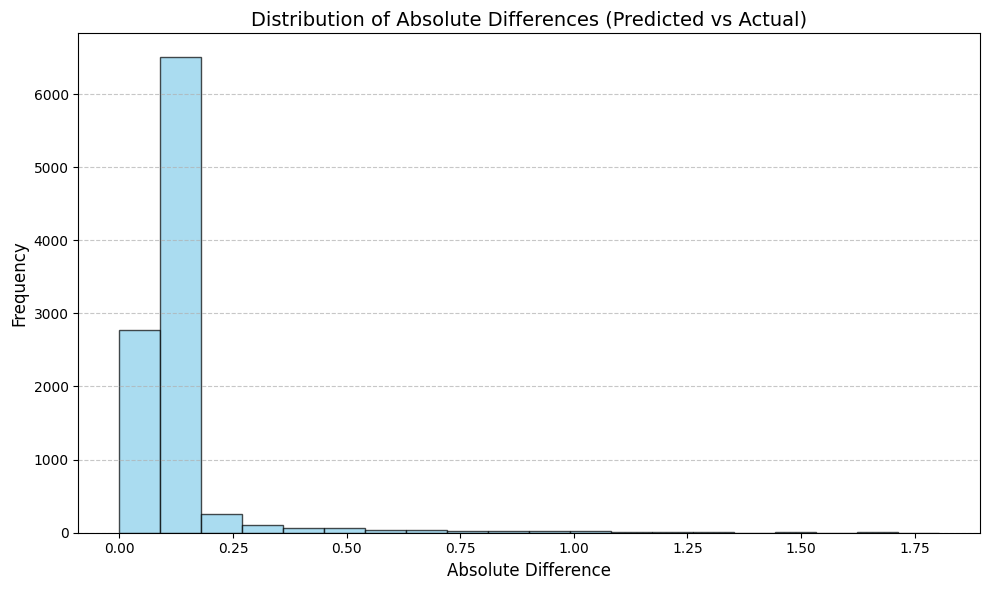

In [ ]:
import torch
import matplotlib.pyplot as plt

# Function to predict for all rows in test_df and plot differences
def predict_and_graph_differences(model, dataset, test_df):
    """
    Predict log_total_flux for all rows in test_df, compute differences, and plot their distribution.

    Args:
        model: Trained PyTorch regression model.
        dataset: Dataset object (FluxDataset) for test data.
        test_df: Pandas DataFrame containing test metadata.
    """
    model.eval()  # Set the model to evaluation mode
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    differences = []  # List to store absolute differences

    # Loop through all rows in test dataset
    for i in range(len(dataset)):
        image, label = dataset[i]  # Get image and label from dataset

        # Ensure the image is a PyTorch tensor, add batch dimension, and move to device
        if isinstance(image, np.ndarray):
            image = torch.tensor(image, dtype=torch.float32)
        image = image.unsqueeze(0).to(device)  # Add batch dimension

        # Predict using the model
        with torch.no_grad():
            predicted_flux = model(image).item()  # Get the single prediction as a scalar

        # Compute the absolute difference
        actual_flux = label.item() if isinstance(label, torch.Tensor) else label
        difference = abs(predicted_flux - actual_flux)
        differences.append(difference)

    # Plot the histogram of differences
    plt.figure(figsize=(10, 6))
    plt.hist(differences, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
    plt.title('Distribution of Absolute Differences (Predicted vs Actual)', fontsize=14)
    plt.xlabel('Absolute Difference', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Predict and graph differences for all rows in test_df
predict_and_graph_differences(model, test_dataset, test_df)

3rd Model

In [ ]:
# 3rd Regression CNN model
# 10 epochs, learning rate 0.001
class RegressionNetwork(nn.Module):
    def __init__(self):
        super(RegressionNetwork, self).__init__()
        # Convolution layers
        self.convolutaional_neural_network_layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=12, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        # Linear layer
        self.linear_layers = nn.Sequential(
            nn.Linear(in_features=24*35*35, out_features=64),  # Adjusted input size
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(in_features=64, out_features=1)  # Single output for regression
        )

    def forward(self, x):
        x = self.convolutaional_neural_network_layers(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.linear_layers(x)
        return x

# Initialize model, loss function, and optimizer
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = RegressionNetwork().to(device)
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
for epoch in range(10):
    model.train()
    train_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        output = model(images)
        loss = criterion(output.squeeze(), labels)  # Squeeze to match shape
        train_loss += loss.item()

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluate on the test set
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            output = model(images)
            loss = criterion(output.squeeze(), labels)
            test_loss += loss.item()

    print(f'Epoch {epoch+1}/10: Train Loss={train_loss/len(train_loader):.4f}, Test Loss={test_loss/len(test_loader):.4f}')


Epoch 1/10: Train Loss=1.9927, Test Loss=0.2997
Epoch 2/10: Train Loss=1.2505, Test Loss=0.1104
Epoch 3/10: Train Loss=0.8129, Test Loss=0.0592
Epoch 4/10: Train Loss=0.5076, Test Loss=0.0442
Epoch 5/10: Train Loss=0.2714, Test Loss=0.0501
Epoch 6/10: Train Loss=0.1425, Test Loss=0.0334
Epoch 7/10: Train Loss=0.0918, Test Loss=0.0416
Epoch 8/10: Train Loss=0.0813, Test Loss=0.0495
Epoch 9/10: Train Loss=0.0822, Test Loss=0.0504
Epoch 10/10: Train Loss=0.0815, Test Loss=0.0489


Results for 3rd model

In [ ]:
# Function to predict and compare flux
def predict_and_compare(model, dataset, num_samples=10):
    model.eval()  # Set the model to evaluation mode
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    predictions = []
    actuals = []
    file_names = []

    # Loop through the first `num_samples` rows of the dataset
    for i in range(num_samples):
        image, label = dataset[i]  # Get image and label from the dataset
        file_name = test_df.iloc[i]['file_name']  # Get the corresponding file_name

        # Convert image to PyTorch tensor, add batch dimension, and move to device
        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0).to(device)

        # Predict using the model
        with torch.no_grad():
            predicted_flux = model(image).item()  # Get the single prediction as a scalar

        # Append results for comparison
        predictions.append(predicted_flux)
        actuals.append(label.item())
        file_names.append(file_name)

    # Print the results
    print(f"{'File Name':<20}{'Predicted':<20}{'Actual':<20}{'Difference':<20}")
    print("-" * 80)
    for file_name, pred, actual in zip(file_names, predictions, actuals):
        print(f"{file_name:<20}{pred:<20.6f}{actual:<20.6f}{abs(pred - actual):<20.6f}")

# Predict and compare the flux for the first 10 rows of test_csv
predict_and_compare(model, test_dataset, num_samples=10)

File Name           Predicted           Actual              Difference          
--------------------------------------------------------------------------------
32643.fits          3.647793            3.712337            0.064545            
50987.fits          3.804711            3.833273            0.028562            
16675.fits          4.324530            4.444304            0.119774            
40761.fits          3.995665            4.070180            0.074515            
84531.fits          4.411434            4.436304            0.024870            
33715.fits          4.370896            4.440171            0.069275            
63863.fits          3.616690            2.466246            1.150444            
68747.fits          4.277138            4.356729            0.079591            
43169.fits          4.257374            4.331399            0.074025            
106470.fits         4.216940            4.299706            0.082767            


<ipython-input-16-131564ad849a>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32).unsqueeze(0).to(device)


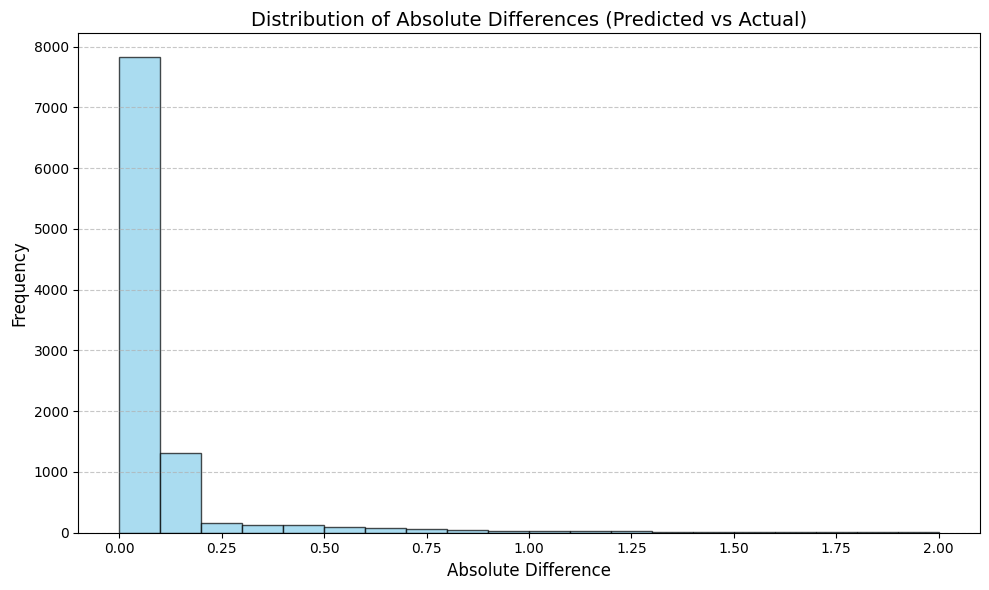

In [ ]:
import torch
import matplotlib.pyplot as plt

# Function to predict for all rows in test_df and plot differences
def predict_and_graph_differences(model, dataset, test_df):
    """
    Predict log_total_flux for all rows in test_df, compute differences, and plot their distribution.

    Args:
        model: Trained PyTorch regression model.
        dataset: Dataset object (FluxDataset) for test data.
        test_df: Pandas DataFrame containing test metadata.
    """
    model.eval()  # Set the model to evaluation mode
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    differences = []  # List to store absolute differences

    # Loop through all rows in test dataset
    for i in range(len(dataset)):
        image, label = dataset[i]  # Get image and label from dataset

        # Ensure the image is a PyTorch tensor, add batch dimension, and move to device
        if isinstance(image, np.ndarray):
            image = torch.tensor(image, dtype=torch.float32)
        image = image.unsqueeze(0).to(device)  # Add batch dimension

        # Predict using the model
        with torch.no_grad():
            predicted_flux = model(image).item()  # Get the single prediction as a scalar

        # Compute the absolute difference
        actual_flux = label.item() if isinstance(label, torch.Tensor) else label
        difference = abs(predicted_flux - actual_flux)
        differences.append(difference)

    # Plot the histogram of differences
    plt.figure(figsize=(10, 6))
    plt.hist(differences, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
    plt.title('Distribution of Absolute Differences (Predicted vs Actual)', fontsize=14)
    plt.xlabel('Absolute Difference', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Predict and graph differences for all rows in test_df
predict_and_graph_differences(model, test_dataset, test_df)